<h1 style="text-align: center;">TP2 Computational Statistique</h1>
<h3 style="text-align: left;">Étudiant : Gravier Thomas <span style="float: right;">Professeure : Stéphanie Allassonnière</span></h3>



# Import

In [3]:
import sklearn as sk
from sklearn.utils import check_random_state




# Exercice 1 :

## Question 2 :

En se référent à notre réponse de la question 1 on peut implémenter l'algorithme ci dessous : 

In [4]:

# Exemple :
# leurs probabilités associées


p = {0.2,0.5,0.3}

# Pour s'adapter à l'exercice 2 on ne donne que p a notre fonction et il nous renverra l'indice du reel dans l'ensemble
# qui sera représenté par une liste X

In [199]:
from sklearn.utils import check_random_state

def discrete_random_var(n, p) : 
    
    sample = [] 
    u = np.random.uniform(0,1,n)
    F = [*[0.0], *np.cumsum(p)] 
    
    for i in range(n): 
        sample.append(np.where(F <= u[i])[0][-1])

    return(sample)

## Question 3 :

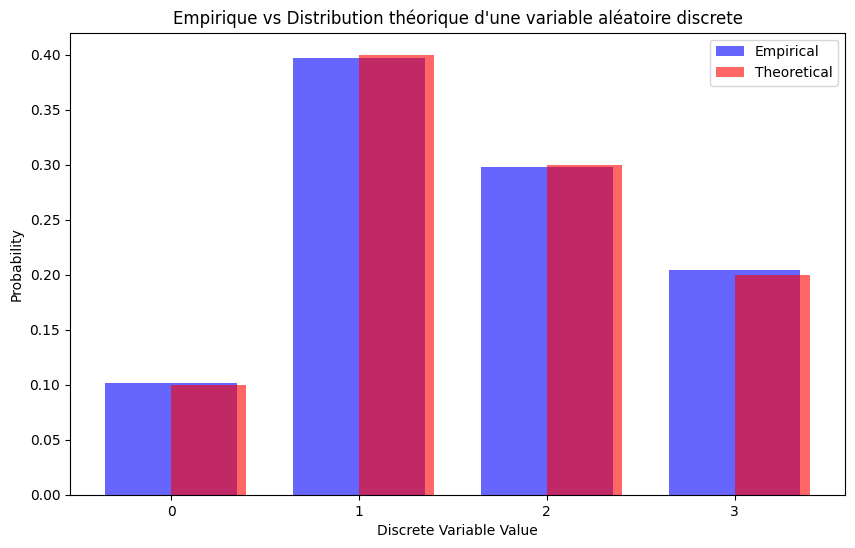

In [6]:
import numpy as np
import matplotlib.pyplot as plt



# Paramètres
n = 10000  # nombre d'échantillons
p = [0.1, 0.4, 0.3, 0.2]  # Probabilités

# Génération des échantillons
samples = discrete_random_var(n, p)




plt.figure(figsize=(10, 6))
plt.hist(samples, bins=np.arange(len(p) + 1) - 0.5, density=True, alpha=0.6, color='b', label="Empirical", rwidth=0.7)
plt.xticks(range(len(p)), range(len(p)))

# Histogramme théorique
plt.bar(np.arange(len(p)) + 0.2, p, alpha=0.6, color='r', width=0.4, label="Theoretical")

# Légendes et affichage
plt.xlabel("Discrete Variable Value")
plt.ylabel("Probability")
plt.legend()
plt.title("Empirique vs Distribution théorique d'une variable aléatoire discrete")
plt.show()


Interprétation :

# Exercice 2 :

## Question 2 :

In [209]:
import numpy as np

# On implémente

n = 10000 # nombre de points générés

alpha = np.array([0.3,0.2,0.5])# Probabilité d'être généré par une gaussienne ou une autre

mu = np.array([[5,1.2],[0,0],[1.5,8.9]]) # Paramètre des moyennes

# Matrice de covariance aléatoire 1
C1 = np.array([[2.3, 0.8], 
               [0.8, 1.5]])

# Matrice de covariance aléatoire 2
C2 = np.array([[1.7, -0.4], 
               [-0.4, 2.2]])

# Matrice de covariance réduite (matrice identité)
C3 = np.array([[1, 0], 
               [0, 1]])

# Regrouper les matrices dans un array nommé 'cov'
cov = np.array([C1, C2, C3]) # Paramètre des covariances

X = []

classe_sample = discrete_random_var(n,alpha)

def sample_mixture(classe_sample, mu,cov):
    X = []
    for classe in classe_sample:
    
        X.append(np.random.multivariate_normal(mu[classe],cov[classe]))
    X= np.vstack(X)
    return X.transpose()

X = sample_mixture(classe_sample,mu, cov)

In [211]:
X

array([[ 3.48880771,  1.2246311 , -1.19281625, ...,  4.92689931,
         2.10699729,  0.06016301],
       [-0.53902281,  7.55151754, -0.31405873, ...,  0.69661495,
        -2.65280718, -0.96661473]])

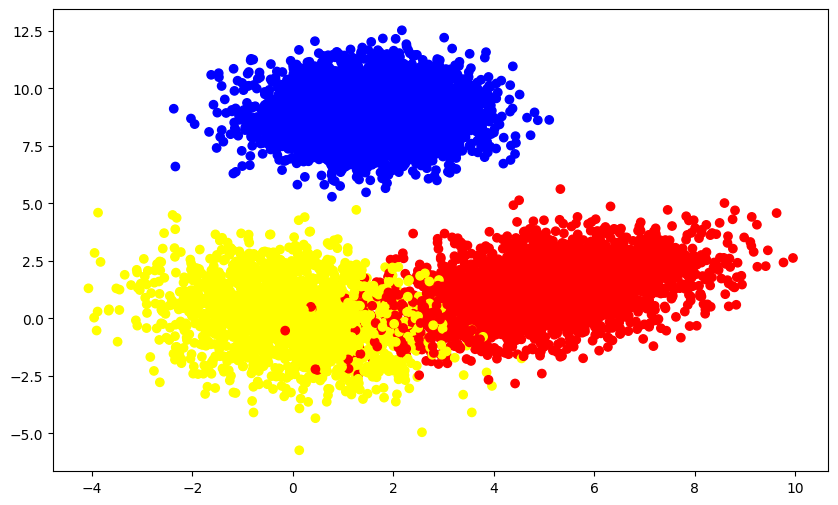

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize= (10,6))

couleur = np.array(['red','yellow','blue'])
plt.scatter(X[0,:],X[1,:], c= couleur[classe_sample] )

plt.show()

## Question 3 :

On crée une fonction qui prends les points X généré précedement et on veut les reclassifiés comme ci dessus

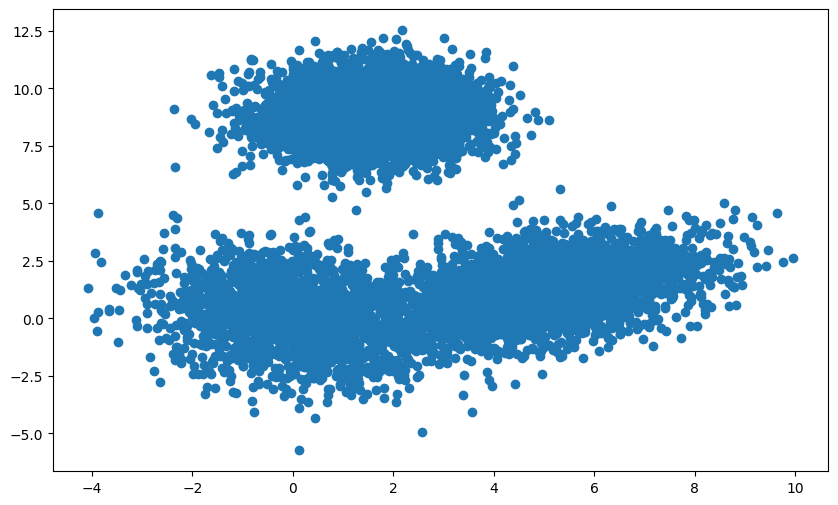

In [213]:
plt.figure(figsize= (10,6))
plt.scatter(X[0,:],X[1,:])
plt.show()

On remarque que les clusters se distingue moins facilement. Pour classifier nous allons utiliser l'algorithme EM en initialisant les différents vecteur avec kmeans. Pour les besoins de l'exercice nous supposerons qu'il y a 3 clusters.

In [214]:
X.shape

(2, 10000)

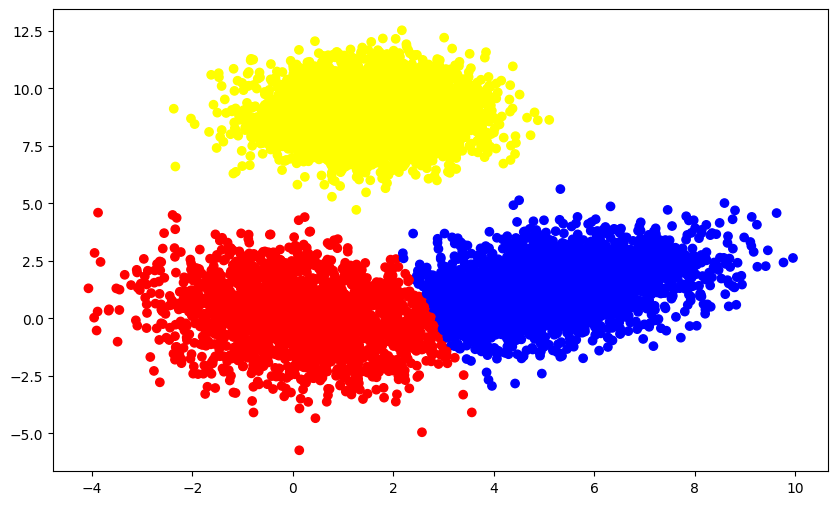

In [215]:
from sklearn.cluster import KMeans


X_kmeans = X.transpose()

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_kmeans)


plt.figure(figsize= (10,6))
plt.scatter(X_kmeans[:,0],X_kmeans[:,1], c = couleur[kmeans.labels_])
plt.show()

Kmeans initialise assez bien les centres des clusters mais nous allons améliorés ça avec l'algorithme EM appliqué a un GMM

In [216]:
X.shape

(2, 10000)

In [217]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

# Hyperparamètres
#m = 3  # nombre de clusters
#d = 2  # dimension des vecteurs

#kmeans_init = kmeans.labels_  # labels assignés par k-means
#nb_point = X.shape[1]  # nombre de points

# Initialisation de tau_0 avec des zéros
#tau = np.zeros((m, nb_point))

# Pour chaque point, on place un 1 dans la ligne correspondant à son cluster
#tau[kmeans_init,np.arange(nb_point)] = 1

import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans

def init_EM(X, m):
    X_kmeans = X.T  # Transposition pour correspondre aux dimensions attendues
    kmeans = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(X_kmeans)
    kmeans_init = kmeans.labels_
    nb_point = X.shape[1]  # Nombre de points dans X

    # Initialisation de tau_0 avec des zéros
    tau = np.zeros((m, nb_point))

    # Pour chaque point, on place un 1 dans la ligne correspondant à son cluster
    tau[kmeans_init, np.arange(nb_point)] = 1

    return tau

def step_M(tau, X):
    d = X.shape[0]  # Dimension des vecteurs
    m = tau.shape[0]  # Nombre de clusters
    nb_point = X.shape[1]  # Nombre de points

    n_repart = np.sum(tau, axis=1)  # Nombre de points par cluster
    alpha = n_repart / nb_point  # Répartition des gaussiennes

    mu = np.zeros((d, m))
    cov = np.zeros((m, d, d))

    for k in range(m):
        if n_repart[k] > 0:  # Éviter la division par zéro
            mu[:, k] = np.sum(tau[k, :] * X / n_repart[k], axis=1)
            
            diff = X - mu[:, k].reshape(d, 1)
            weighted = tau[k, :] * diff
            cov[k] = weighted @ diff.T / n_repart[k]


    return alpha, mu, cov

def log_likelihood(densite):
    log_lh = np.sum(np.log(np.sum(densite, axis=0)))
    return log_lh

def compute_densite(alpha, mu, cov, X):
    d = X.shape[0]
    nb_points = X.shape[1]

    densite = []

    for idx, (mean, covariance) in enumerate(zip(mu.T, cov)):
        mn = multivariate_normal(mean=mean, cov=covariance)
        densite_mc = alpha[idx] * mn.pdf(X.T)  # Calcul des densités pour chaque point de X
        densite.append(densite_mc)

    densite = np.vstack(densite)  # Conversion en array pour faciliter les calculs

    return densite

def compute_tau(densite):
    tau = densite / np.sum(densite, axis=0)  # Normalisation pour obtenir les probabilités
    return tau

def algorithme_EM(X, nb_cluster, eps):
    d = X.shape[0]
    m = nb_cluster

    tau_0 = init_EM(X, m)
    alpha_0, mu_0, cov_0 = step_M(tau_0, X)
    densite_0 = compute_densite(alpha_0, mu_0, cov_0, X)
    log_lh_0 = log_likelihood(densite_0)

    tau = compute_tau(densite_0)
    previous_likelihood = log_lh_0
    liste_lh = [previous_likelihood]
    f=0
    while True:
        alpha, mu, cov = step_M(tau, X)
        densite = compute_densite(alpha, mu, cov, X)

        log_lh = log_likelihood(densite)
        liste_lh.append(log_lh)

        erreur = np.abs(log_lh - previous_likelihood)

        if erreur < eps:
            break

        tau = compute_tau(densite)
        previous_likelihood = log_lh


    return alpha, mu, cov, tau, liste_lh


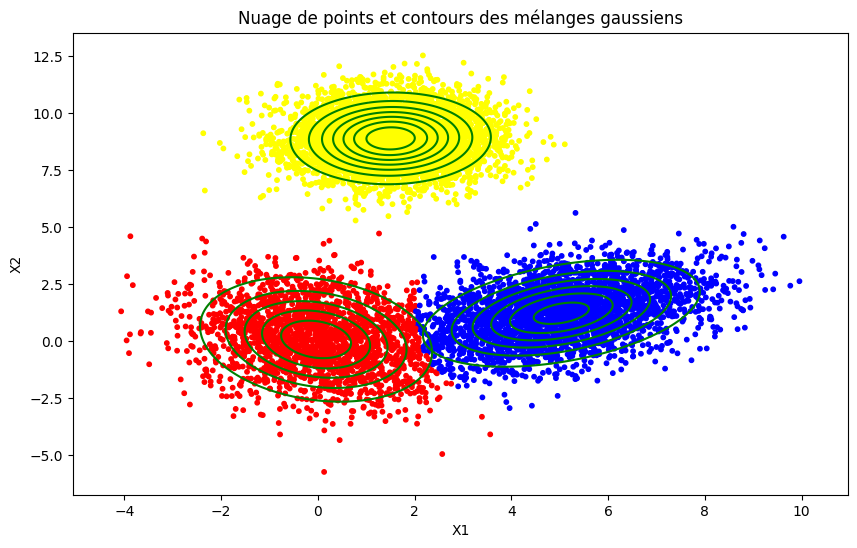

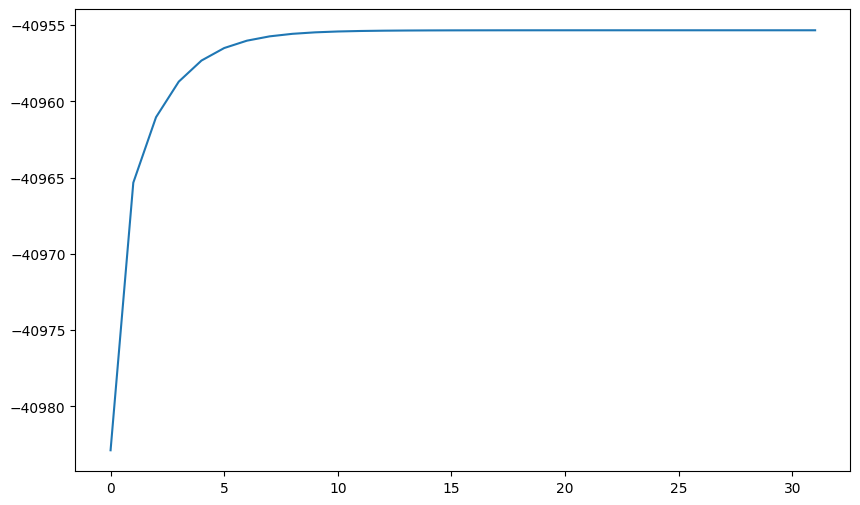

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

alpha_em, mu_em, cov_em ,tau_em, liste_lh = algorithme_EM(X, 3, 1E-6)

classe = np.argmax(tau_em,axis=0)
couleur = np.array(['red','yellow','blue','grey','brown','purple'])


mu_em = mu_em.T

# Exemple de données du mélange gaussien
# Assurez-vous que `alpha`, `mu` et `cov` sont définis

# Nuage de points
plt.figure(figsize=(10, 6))





plt.scatter(X[0, :], X[1, :], c=couleur[classe], label='Nuage de points', s=10)

# Définir les limites pour les contours
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
pos = np.dstack((x, y))

# Dessiner chaque composante du mélange gaussien
for i in range(len(alpha_em)):
    rv = multivariate_normal(mean=mu_em[i], cov=cov_em[i])
    plt.contour(x, y, rv.pdf(pos), levels=7, colors='green', linewidths=1.5)

# Affichage final

plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Nuage de points et contours des mélanges gaussiens")
plt.show()

# Nuage de points
plt.figure(figsize=(10, 6))

plt.plot(liste_lh)
plt.show()


## Question 4 :

In [219]:
print("Résultats de l'algorithme EM et des valeurs initiales :")
print("\nVecteurs de moyennes :")
print(f"  - Vecteur de moyenne de EM : {mu_em}")
print(f"  - Vecteur de moyenne initial : {mean}")

print("\nMatrices de covariances :")
print(f"  - Matrice de covariance de EM : {cov_em}")
print(f"  - Matrice de covariance initiale : {cov}")

print("\nVecteurs alpha :")
print(f"  - Vecteur alpha de EM : {alpha_em}")
print(f"  - Vecteur alpha initial : {alpha}")


Résultats de l'algorithme EM et des valeurs initiales :

Vecteurs de moyennes :
  - Vecteur de moyenne de EM : [[-0.03637751  0.07095678]
 [ 1.50460718  8.88779152]
 [ 5.03383263  1.2190568 ]]
  - Vecteur de moyenne initial : 0.8

Matrices de covariances :
  - Matrice de covariance de EM : [[[ 1.62379776 -0.38468371]
  [-0.38468371  2.10252601]]

 [[ 1.03884195  0.02786803]
  [ 0.02786803  0.97890502]]

 [[ 2.1944146   0.73275219]
  [ 0.73275219  1.47331699]]]
  - Matrice de covariance initiale : [[[ 2.3  0.8]
  [ 0.8  1.5]]

 [[ 1.7 -0.4]
  [-0.4  2.2]]

 [[ 1.   0. ]
  [ 0.   1. ]]]

Vecteurs alpha :
  - Vecteur alpha de EM : [0.19825344 0.50381144 0.29793511]
  - Vecteur alpha initial : [0.3 0.2 0.5]


Nous observons que les valeurs obtenues sont très proches des valeurs initiales, avec une précision de l'ordre de \(10^{-3}\),  avec notre choix d'utiliser 3 clusters et un critère de convergence basé sur un epsilon de \(10^{-6}\) appliqué à la log-vraisemblance.


## Question 5 :

In [37]:
import pandas as pd

In [77]:
df = pd.read_csv('WPP2024_Demographic_Indicators_Medium.csv', low_memory=False)[['CBR', 'CDR']].dropna()
X = df.to_numpy()
X= X.T

In [94]:
alpha_em, mu_em, cov_em ,tau_em, liste_lh = algorithme_EM(X, 3, 1E-6)

classe = np.argmax(tau_em, axis=0)
couleur = np.array(['red', 'yellow', 'blue', 'grey', 'brown', 'purple'])

mu_em = mu_em.T

In [89]:
point_colors

array([[2.61124111e-020, 6.97365816e-170, 1.00000000e+000],
       [4.50643710e-019, 3.73799969e-168, 1.00000000e+000],
       [4.21072479e-018, 2.02311057e-167, 1.00000000e+000],
       ...,
       [1.29062959e-005, 9.99987094e-001, 3.74700790e-016],
       [8.70273367e-006, 9.99991297e-001, 4.08294197e-016],
       [5.98840202e-006, 9.99994012e-001, 4.58997276e-016]])

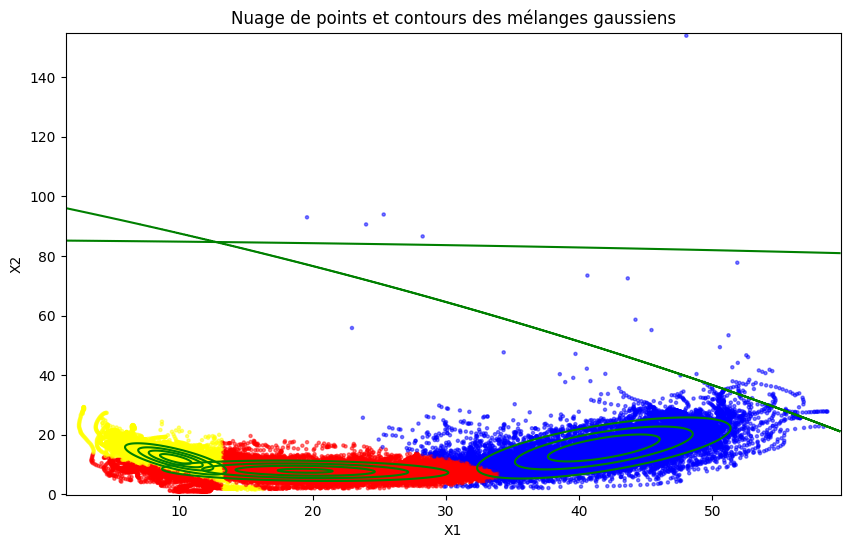

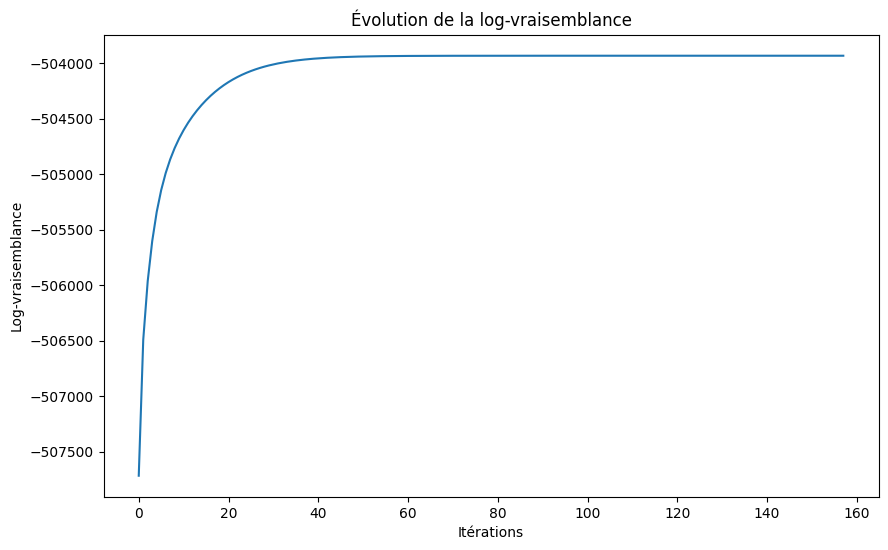

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as patches


# Nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(X[0, :], X[1, :], c=couleur[classe], label='Nuage de points', s=5,alpha=0.5)

# Définir les limites pour les contours
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
pos = np.dstack((x, y))

# Seuil de distance pour dessiner les ellipses
distance_seuil = 0.05  # Ajustez ce seuil selon vos besoins

# Dessiner chaque composante du mélange gaussien avec des ellipses
for i in range(len(alpha_em)):
    rv = multivariate_normal(mean=mu_em[i], cov=cov_em[i])
    plt.contour(x, y, rv.pdf(pos), levels=4, colors='green', linewidths=1.5)
    
    # Calculer la distance moyenne des points du cluster par rapport au centre
    distances = np.linalg.norm(X[:, classe == i].T - mu_em[i], axis=1)
    distance_moyenne = np.mean(distances)
    
    # Ajouter des ellipses seulement si la distance moyenne est inférieure au seuil
    if distance_moyenne <= distance_seuil:
        eigvals, eigvecs = np.linalg.eigh(cov_em[i])
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(eigvals)
        
        ellipse = patches.Ellipse(mu_em[i], width, height, angle=angle, edgecolor='green', facecolor='none', linewidth=1.5)
        plt.gca().add_patch(ellipse)

# Affichage final
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("Nuage de points et contours des mélanges gaussiens")
plt.show()

# Affichage de la courbe de log-vraisemblance
plt.figure(figsize=(10, 6))
plt.plot(liste_lh)
plt.xlabel("Itérations")
plt.ylabel("Log-vraisemblance")
plt.title("Évolution de la log-vraisemblance")
plt.show()


Avec 3 clusters, on observe que les taux de natalité et de mortalité varient en fonction du pays et de la période considérée. On peut identifier un groupe caractérisé par une "faible mortalité et faible natalité" à gauche, un autre avec une "forte mortalité et forte natalité", et un troisième présentant une "faible mortalité et une natalité moyenne". L'algorithme EM permet ainsi de classer les données de manière compréhensible et interprétable.

### Sélection de modèle - Bayesian Information Criterion

On compte le nombre de paramètres et degrés de libertés d'un modèle de mélange gaussien avec $p$ composantes : 
- $\alpha_j : p$ paramètres avec la contrainte $\displaystyle\sum_{j=1}^p{\alpha_j} = 1$ d'où  l'on tire $p-1$ degrés de libertés.
- $\mu_j : p\times d$ paramètres indépendants d'où $p\times d$ degrés de libertés.
- $\Sigma_j : \displaystyle p\times d^2 $ paramètres avec la contrainte $\Sigma^T = \Sigma$ d'où $ p\times \frac{d(d+1)}{2}$ degrés de libertés.

Le nombre total de degrés de libertés est donc $p\times(d+1)\times(d + 2)/2 - 1$

In [113]:
def bic(alpha, mu, cov, lh, X):

    log_lh = lh

    # Calcul du nombre de paramètres
    p = len(alpha)
    d = X.shape[0]

    # Nombre de degrés de liberté total
    num_params = p * (d + 1) * (d + 2) / 2 - 1

    # Calcul du BIC
    n = X.shape[1]  # Nombre de points de données
    bic_value = -(log_lh - (num_params / 2) * np.log(n))

    return bic_value

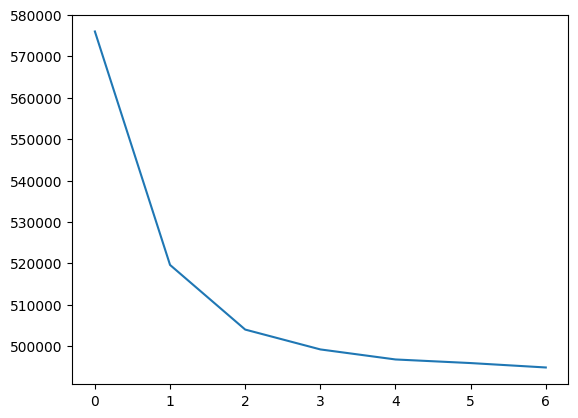

In [115]:
cluster_max = 8

bics = []

for i in range(1,cluster_max):

    alpha_em, mu_em, cov_em ,_, liste_lh = algorithme_EM(X, i, 1E-6)
    bic_i = bic(alpha_em, mu_em, cov_em, liste_lh[-1], X)
    bics.append(bic_i)

plt.plot(bics)
plt.show()

    

On constate ainsi que, plus la valeur de $p$ augmente, plus le modèle s'adapte à notre jeu de données. Toutefois, le critère BIC n'empêche pas le phénomène de sur-apprentissage. Néanmoins, on remarque que ce critère atteint un plateau à partir de $p=3$, ce qui suggère que le modèle avec 3 composantes est le plus simple et le mieux ajusté aux données.

Le tracé avec 3 clusters est présenté ci-dessus. J'ai assigné les points en fonction de l'argmax de leurs vecteurs $\tau$. Une alternative aurait été de réaliser un dégradé de couleurs représentant la probabilité d'appartenance de chaque point à un cluster. Cependant, j'ai rencontré un problème avec le tracé des ellipses de contours : celles-ci incluent les points aberrants, et je n'arrive pas à supprimer les contours non significatifs.








# Exercise 3: Importance sampling

## Question 1 :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def f(x):

    return 2 * np.sin(np.pi/1.5 * x) * (x>=0)

def p(x):

    return x**(1.65-1) * np.exp(-0.5*x**2) * (x>=0)




def q(x,mu,sigma_carre):

    rv = norm(mu,np.sqrt(sigma_carre))

    return  2* rv.pdf(x)  * (x>=0)



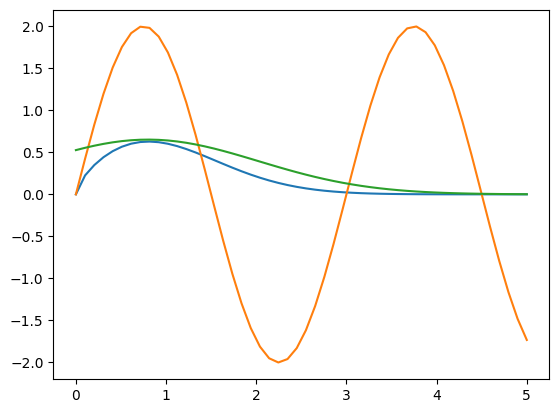

In [3]:
x= np.linspace(0,5)
plt.plot(x,p(x))
plt.plot(x,f(x))
plt.plot(x,q(x,0.8,1.5))
plt.show()


In [57]:
from scipy.stats import norm
import numpy as np
import seaborn as sn

# On s'assure d'avoir une fonction optimiser qui sample que des nombres positif avec sampled_from_q fonction recursive

def sampled_from_q(mu, sigma_carre, N):

    rv = norm(mu, np.sqrt(sigma_carre))
    samples = 2*rv.rvs(N)


    def remove_and_replace_negatives(samples):
        negative_samples = samples[samples < 0]
        
        if len(negative_samples) > 0:

            samples = samples[samples >= 0]

            additional_samples = 2*rv.rvs(len(negative_samples))
            # Combine non-negative additional samples recursively
            return remove_and_replace_negatives(np.concatenate((samples, additional_samples)))
        else:
            return samples


    samples = remove_and_replace_negatives(samples)

    return np.array(samples)







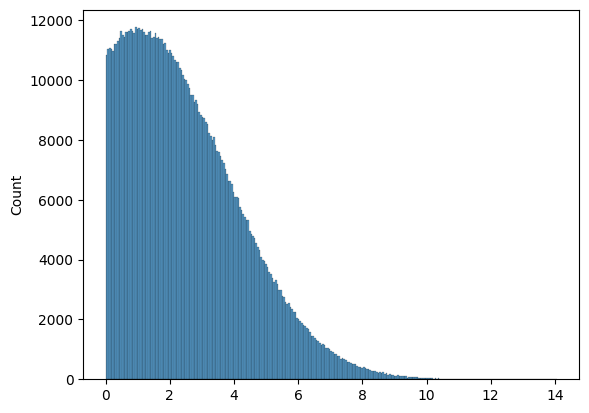

In [58]:
sn.histplot(sampled_from_q(0.5,1.8,1000000))
plt.show()

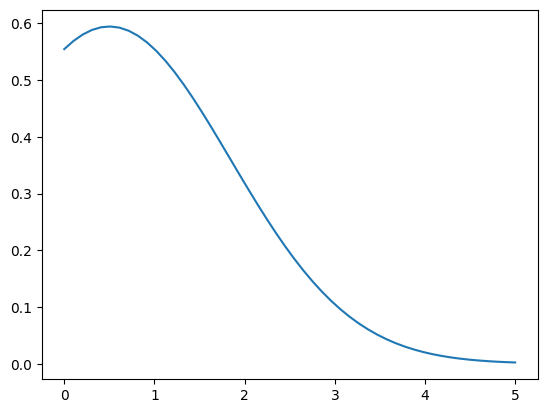

In [59]:
plt.plot(np.linspace(0,5),q(np.linspace(0,5),0.5,1.8))
plt.show()

La distribution sur laquel on sample est la bonne au vue de l'histogramme.

In [82]:
def compute_estimateur(N_samples, mu, sigma_carre):
   

    
    samples = sampled_from_q(mu, sigma_carre, N_samples)
    
    rv = norm(mu, np.sqrt(sigma_carre))      
    p_x = p(np.array(samples))
    q_x = 2*rv.pdf(np.array(samples))
    f_x = f(np.array(samples))
    w = p_x / q_x


    weight_norm = w/np.mean(w)
    estimateur = np.mean(weight_norm*f_x)
    
    
    

    return estimateur

In [83]:
mu = 0.8
sigma_carre = 1.5
compute_estimateur(100000, mu, sigma_carre)

0.47337907018493114

La fonction pour effectuer le Poor Importance Sampling est compute_estimateur qui prends en argument le nombre d'échantillons.

## Question 2 : 

On crée une fonction qui crée une liste d'estimateur.

In [97]:

def liste_estimateur(N,mu, sigma_carre):
    
    estimateur_liste = []

    for i in range(500): # 500 estimateurs sont considérés comme suffisant pour avoir la moyenne et la variance.

        
        
    

        
        
        estimateur = compute_estimateur(N,mu,sigma_carre)
        estimateur_liste.append(estimateur)
        
    return estimateur_liste


Puis, nous utilisons la fonction pour obtenir 500 estimateurs, ce qui nous permet de calculer la moyenne et la variance pour différentes valeurs d'échantillonnage 
𝑁

In [99]:
N = [10, 100, 1000, 10000]

mu, sigma_carre = 0.8, 1.5


mean_estimateur = []
var_estimateur = []

for n in N:

    estimateur_liste = liste_estimateur(n,mu,sigma_carre)
    mean_estimateur.append(np.mean(estimateur_liste))
    var_estimateur.append(np.var(estimateur_liste))
                           
    

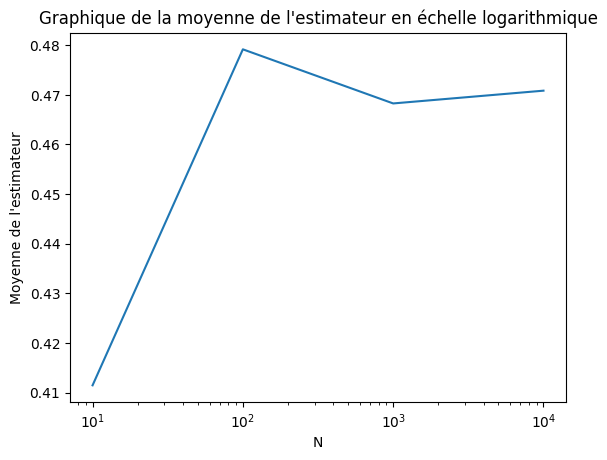

In [100]:
plt.semilogx(N, mean_estimateur)
plt.xlabel('N')
plt.ylabel("Moyenne de l'estimateur")
plt.title("Graphique de la moyenne de l'estimateur en échelle logarithmique")
plt.show()

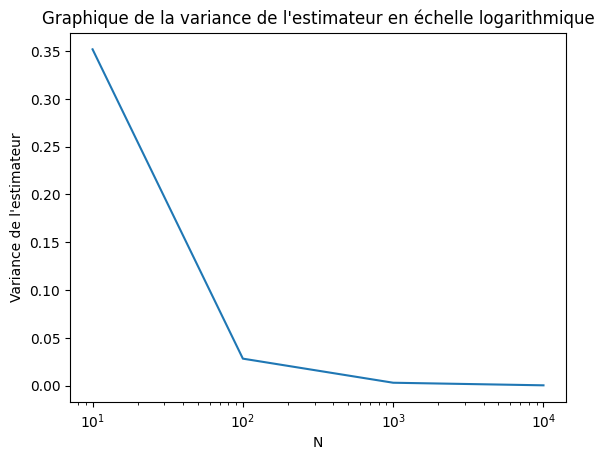

In [101]:
plt.semilogx(N, var_estimateur)  # Utilise directement une échelle logarithmique pour l'axe y
plt.xlabel('N')
plt.ylabel("Variance de l'estimateur")
plt.title("Graphique de la variance de l'estimateur en échelle logarithmique")
plt.show()


## Question 3 :

Comme mentionné dans l'énoncé de la question, nous effectuons la modification en utilisant $\mu$ = 6.


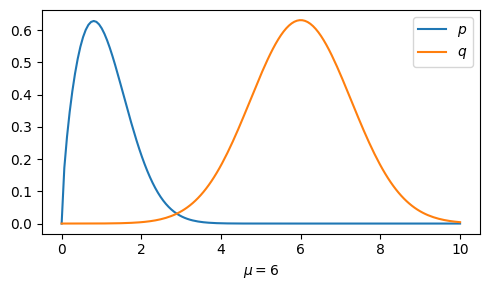

In [102]:
x = np.linspace(0, 10, 150)
plt.figure(figsize=(5,3))
plt.plot(x, p(x), label=r'$p$')
plt.plot(x, q(x, 6, 1.6), label=r'$q$')
plt.xlabel(r'$\mu=6$')
plt.legend()
plt.tight_layout()
plt.show()

### Question 3.1 :

On refait l'expérience avec $\mu$ = 6

In [103]:
N = [10, 100, 1000, 10000]

mu = 6
sigma_carre = 1.5


mean_estimateur = []
var_estimateur = []

for n in N:

    estimateur_liste = liste_estimateur(n,mu,sigma_carre)
    mean_estimateur.append(np.mean(estimateur_liste))
    var_estimateur.append(np.var(estimateur_liste))
                           
    

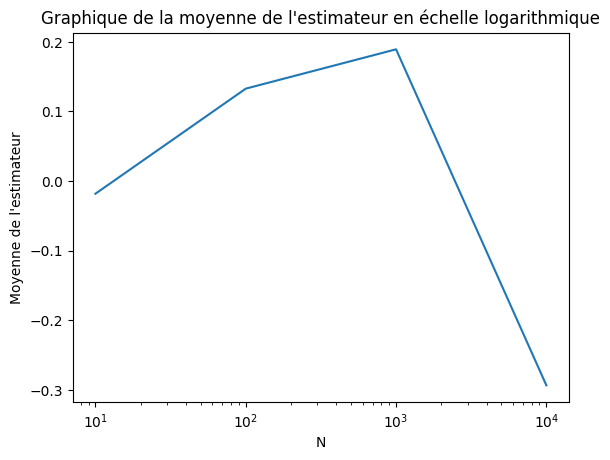

In [104]:
plt.semilogx(N, mean_estimateur)
plt.xlabel('N')
plt.ylabel("Moyenne de l'estimateur")
plt.title("Graphique de la moyenne de l'estimateur en échelle logarithmique")
plt.show()

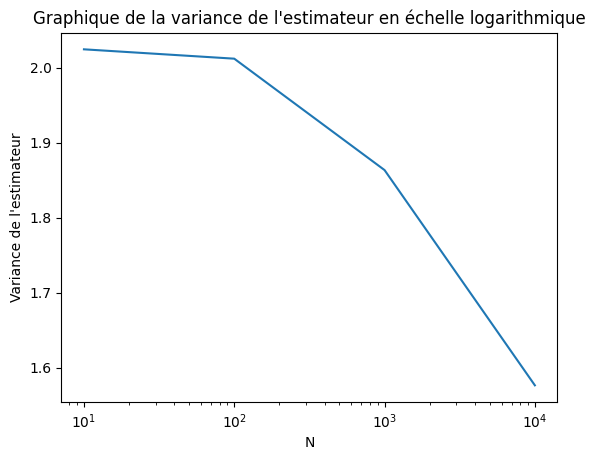

In [105]:
plt.semilogx(N, var_estimateur)  # Utilise directement une échelle logarithmique pour l'axe y
plt.xlabel('N')
plt.ylabel("Variance de l'estimateur")
plt.title("Graphique de la variance de l'estimateur en échelle logarithmique")
plt.show()


### Question 3.2 :

In [141]:
N = 1000
means = [0.8, 6]
sigma_carre = 1.5

def compute_weights(N_samples, mu, sigma_carre):
   

    
    samples = sampled_from_q(mu, sigma_carre, N_samples)
    
    rv = norm(mu, np.sqrt(sigma_carre))      
    p_x = p(np.array(samples))
    q_x = 2*rv.pdf(np.array(samples))
    f_x = f(np.array(samples))
    w = p_x / q_x


    weight_norm = w/np.mean(w)

    
    
    

    return weight_norm, samples

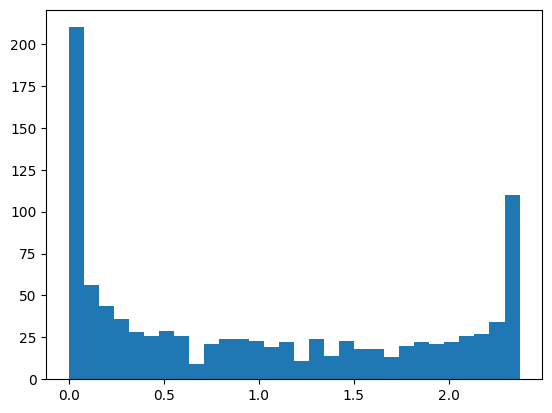

In [142]:
weights0, x_0 = compute_weights(N, means[0], sigma_carre)

# Affichez l'histogramme avec les bacs spécifiés
plt.hist(weights0, bins=30)
plt.show()

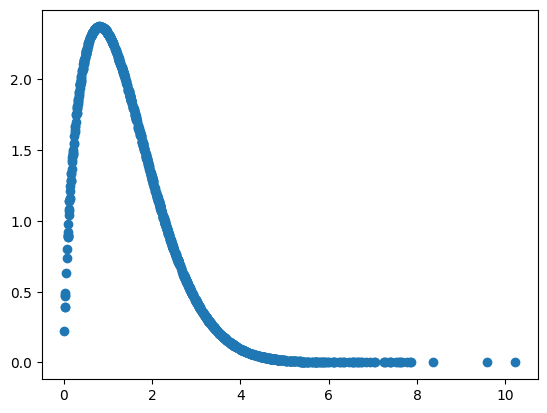

In [144]:
plt.scatter(x_0, weights0)
plt.show()

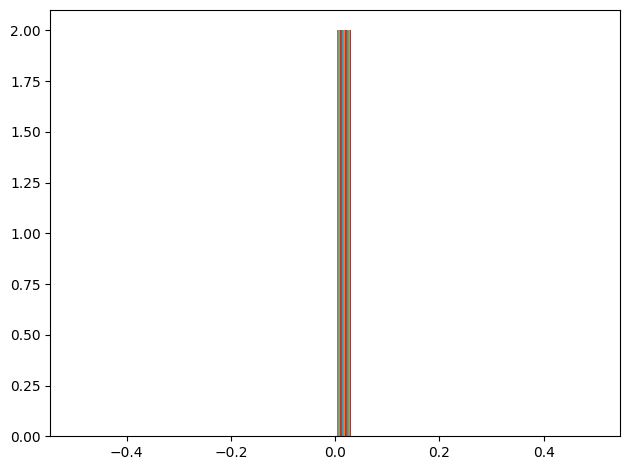

In [140]:
weights1, x_1 = compute_weights(N, means[1], sigma_carre)

# Affichez l'histogramme avec les bacs spécifiés
plt.hist(weights, bins=30)
plt.tight_layout()
plt.show()

In [149]:
weights1, x_1 = compute_weights(N, means[1], sigma_carre)

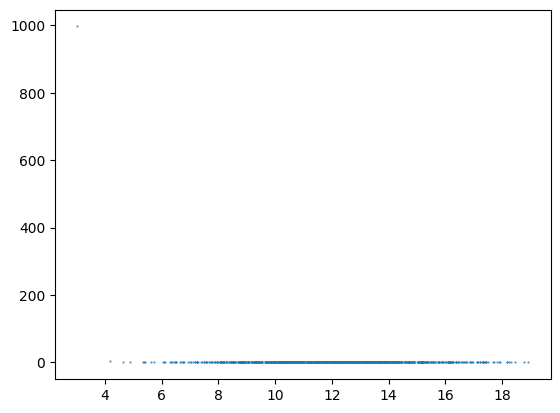

In [153]:
plt.scatter(x_1, weights1, s=0.2)
plt.show()

Pour conclure sur l'**importance sampling** poor, on observe que le choix de la distribution est crucial. Il est nécessaire de choisir une distribution dont la densité est concentrée là où se trouve le plus d'information dans la fonction à échantillonner. Ce n'est pas le cas avec notre distribution pour \\(\mu = 6\\), mais cela l'est beaucoup plus avec \\(\mu = 0.8\\).


## Question 4 :

> (iii) $\Longleftrightarrow$ Maximiser $\sum_{i=1}^n \tilde{w_i}^{(0)} \log (\sum_{j=1}^M \alpha_j \phi(X_i^{(0)};\theta_j))$

<br><br>

> Ce qui est une approximation pour l’étape : Maximisation $\int \log(\sum_{i=1}^M \alpha_i \phi(x,\mu_i, \Sigma_i)) ~\nu(x)~ dx$

<br><br>

> Cette maximisation ressemble formellement à l’estimation du maximum de vraisemblance standard pour un mélange, mais avec une intégration par rapport à $\nu$ remplaçant la somme empirique sur les observations.

<br><br>

> Cette analogie suggère qu’il est possible de maximiser le critère précédent en utilisant l’algorithme EM. Cependant, les paramètres ont changé pour inclure les valeurs des poids.

<br><br>

> Ainsi, nous avons :

<br><br>

$$\alpha_c = \frac{\sum_i \tau_{ic}\tilde{w_i}}{\sum_c \sum_i \tau_{ic}\tilde{w_i}}$$

<br><br>

$$\mu_c = \frac{\sum_i \tau_{ic}\tilde{w_i} x_i}{\sum_i \tau_{ic}\tilde{w_i}}$$

<br><br>

$$\sigma_c = \frac{\sum_i \tau_{ic}\tilde{w_i} (x_i - \mu_c)^T(x_i - \mu_c)}{\sum_i \tau_{ic}\tilde{w_i}}$$

<br><br>

> Avec $\tau_{ic} = \frac{\alpha_c \phi(x_i | \mu_c,\Sigma_c)}{\sum_{k=1}^K \alpha_k \phi(x_i | \mu_k,\Sigma_k)}$  

<br><br>

Où : $\phi(x|\mu, \Sigma)$ décrit la gaussienne multivariée.



## Question 5 :

In [424]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans







def init_mixture(nb_clusters, d):

    alpha = np.zeros((nb_clusters,1))
    alpha[: , 0] = 1/nb_clusters

    mu = np.random.randn(nb_clusters, d) # a voir
    
    cov = np.zeros((nb_clusters, d, d)) + np.eye(d)
    
    return alpha, mu , cov

from sklearn.utils import check_random_state

def discrete_random_var(n, p) :  # fonction de l'exercice 1
    
    sample = [] 
    u = np.random.uniform(0,1,n)
    F = [*[0.0], *np.cumsum(p)] 
    
    for i in range(n): 
        sample.append(np.where(F <= u[i])[0][-1])

    return(sample)

def sample_mixture(classe_sample, mu,cov): # fonction de l'exercice 2
    X = []
    for classe in classe_sample:
    
        X.append(np.random.multivariate_normal(mu[classe],cov[classe]))
    X= np.vstack(X)
    return X.transpose()

def p(X, sigma, d, b):
    X = X.T
    # Sigma 
    Cov = np.eye(d)
    Cov[0,0] = sigma**2
    
    # Null means 
    mu = np.zeros(d)
    
    # Generates density  
    sample = X.copy()
    sample[:,1] -= b*(sample[:,0]**2 - sigma**2) 
    sample = multivariate_normal.pdf(sample, mu, Cov)
    
    return(sample)

# fonction q 
def q(X, alpha, mu, cov) : 
    X = X.T
    aux = np.zeros((X.shape[0], alpha.shape[0]))
    
    for j in range(alpha.shape[0]):
        f = multivariate_normal.pdf(X, mu[j], cov[j], allow_singular=True)
        aux[:,j] = alpha[j] * f
    
    return(np.sum(aux, axis = 1))

# fonction to compute weights 
def weight(X,alpha,mu,cov,sigma,d,b):
    
    p_prob = p(X, sigma, d, b)    
    q_prob = q(X , alpha, mu, cov)
    
    w = p_prob/q_prob 
    w /= np.mean(w)

    return w
        
        



def step_M_modified(tau, w, X):
    d = X.shape[0]  # Dimension des données
    m = tau.shape[0]  # Nombre de composantes
    nb_point = X.shape[1]  # Nombre de points de données

    # Multiplier chaque colonne de tau par le poids correspondant
    for k in range(nb_point):
        tau[:, k] *= w[k]

    # Calculer alpha (les poids normalisés pour chaque composante)
    alpha = np.sum(tau, axis=1)

    # Initialiser mu et cov
    mu = np.zeros((d, m))
    cov = np.zeros((m, d, d))

    # Calculer mu et cov pour chaque composante
    for k in range(m):
        if alpha[k] > 0:
            # Calcul de mu
            mu[:, k] = np.sum(tau[k, :] * X, axis=1) / alpha[k]
            
            # Calcul de la covariance
            diff = X - mu[:, k].reshape(d, 1)
            weighted_diff = tau[k, :] * diff
            cov[k] = weighted_diff @ diff.T / alpha[k]

    return alpha, mu, cov


def log_likelihood(densite):
    log_lh = np.sum(np.log(np.sum(densite, axis=0)))
    return log_lh

def compute_densite(alpha, mu, cov, X):
    d = X.shape[0]
    nb_points = X.shape[1]

    densite = []

    for idx, (mean, covariance) in enumerate(zip(mu.T, cov)):
        mn = multivariate_normal(mean=mean, cov=covariance, allow_singular=True)
        densite_mc = alpha[idx] * mn.pdf(X.T)  # Calcul des densités pour chaque point de X
        densite.append(densite_mc)

    densite = np.vstack(densite)  # Conversion en array pour faciliter les calculs

    return densite

def compute_tau(densite):
    tau = densite / np.sum(densite, axis=0)  # Normalisation pour obtenir les probabilités
    return tau

def algorithme_EM_IS(nb_cluster, m, b, sigma, n_samples ,n_iter):

    # On initialise
    alpha, mu, cov = init_mixture(nb_cluster,m)

    for i in range(n_iter): # On pourrait l'améliorer avec un critère d'arrêt sur la log-likelihood, mais ce critère simplifie l'algorithme
        # Calcule des poids
        classe_sample = discrete_random_var(n_samples,alpha)
        X = sample_mixture(classe_sample,mu,cov)
        W = weight(X,alpha,mu,cov,sigma,m,b)
        W = np.array(W)
        #E-step

        densite = compute_densite(alpha, mu, cov, X)
        tau = compute_tau(densite)

        #M-step modifiée pour IS

        
        alpha, mu, cov = step_M_modified(tau, W, X)

    return alpha, mu, cov, tau




In [450]:
nb_cluster=5
m = 5 # dimension des vecteurs
b= 1
sigma = 1

n_iter = 50
n_samples = 5000





alpha, mu, cov, tau = algorithme_EM_IS(nb_cluster, m, b, sigma, n_samples ,n_iter)   

        

        
        

In [452]:
#alpha, mu, cov, tau = algorithme_EM_IS(nb_cluster, m, b, sigma, n_samples ,n_iter)
classe_sample = discrete_random_var(10000,alpha)
X = sample_mixture(classe_sample,mu,cov)


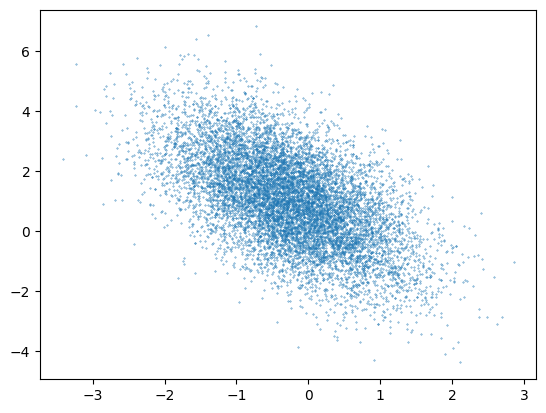

In [455]:
plt.scatter(X[0,:],X[1,:], s=0.1)

Mon algorithme ne fonctionne pas, je n'arrive pas à trouver l'erreur qui redonne la densité en forme de banane.